# DecisionTree + NewDummies

Refazendo a árvore de decisão utilizando o novo dataset com dummies gerado no arquivo 11.

## Preparando o ambiente

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
mpl.rcParams['figure.figsize'] = (12, 7)
sns.set(style='darkgrid')

In [3]:
SEED = 42 # Vida, universo e tudo mais
np.random.seed(SEED)

## Carregando os dados

In [4]:
treino = pd.read_csv('https://raw.githubusercontent.com/SalatielBairros/kaggle-titanic/main/data/processed_v2/train_dummies.csv')
teste = pd.read_csv('https://raw.githubusercontent.com/SalatielBairros/kaggle-titanic/main/data/processed_v2/test_dummies.csv')
del treino['Unnamed: 0']
del teste['Unnamed: 0']
del teste['Fare']
del treino['Fare']
#teste['Fare'].fillna(teste['Fare'].mean(), inplace=True)
Xvalidation = teste.drop(columns=['PassengerId'])
treino.head(2)

,Survived,Pclass,Age,SibSp,Parch,Relateds,possui_cabine,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22,1,0,1,0,0,1,0,0,1
1,1,1,38,1,0,1,1,1,0,1,0,0


In [5]:
X = treino.drop(columns=['Survived'])
y = treino['Survived']

## Separando treino e teste

In [6]:
treino_x, teste_x, treino_y, teste_y = train_test_split(X, y, test_size = 0.2, stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

Treinaremos com 712 elementos e testaremos com 179 elementos


## Executando `DecisionTree` sem normalização

In [7]:
def dt_grid_search(treino_x, treino_y, teste_x, teste_y):
    criterion = ["gini", "entropy"]
    max_depth = [3, 5, 7, 11, 18, 25, 50]
    min_samples_split = [8, 16, 24]
    min_samples_leaf = [2, 8, 16, 32]
    resultados = []

    for c in criterion:
        for md in max_depth:
            for ms in min_samples_split:
                for ml in min_samples_leaf:
                    modelo = DecisionTreeClassifier(criterion = c, max_depth = md, min_samples_split = ms, min_samples_leaf = ml)
                    modelo.fit(treino_x, treino_y)
                    train_score = modelo.score(treino_x, treino_y)
                    test_score = modelo.score(teste_x, teste_y)
                    resultados.append({
                        "criterion": c,
                        "max_depth" : md,
                        "min_samples_split": ms,
                        "min_samples_leaf": ml,
                        "train_score": train_score,
                        "test_score": test_score
                    })

    return pd.DataFrame(resultados)

In [8]:
resultados = dt_grid_search(treino_x, treino_y, teste_x, teste_y)

In [9]:
resultados.query('train_score > 0.78 and test_score > 0.78').sort_values(by=['test_score', 'train_score'], ascending=[False, False]).head(2)

,criterion,max_depth,min_samples_split,min_samples_leaf,train_score,test_score
156,entropy,50,8,2,0.896067,0.793296
0,gini,3,8,2,0.830056,0.793296


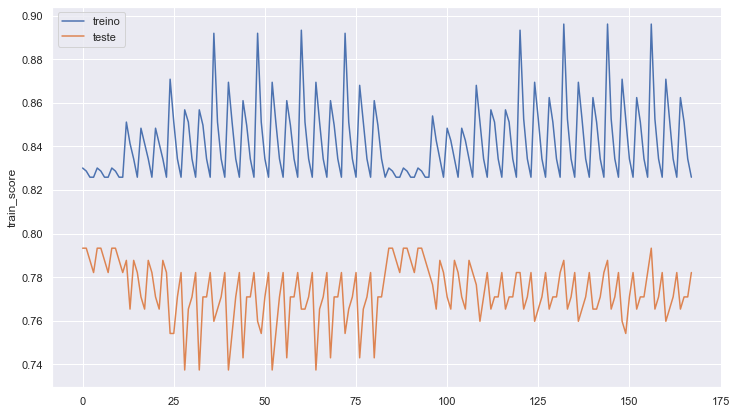

In [10]:
sns.lineplot(y=resultados['train_score'], x=resultados.index, label='treino')
sns.lineplot(y=resultados['test_score'], x=resultados.index, label='teste');

### Treinando com o melhor resultado de `test_score`

In [11]:
best_params = resultados.sort_values(by=['test_score', 'train_score'], ascending=[False, False]).head(1).drop(columns=['test_score', 'train_score']).to_dict(orient='records')[0]
best_params

{'criterion': 'entropy',
 'max_depth': 50,
 'min_samples_split': 8,
 'min_samples_leaf': 2}

In [12]:
modelo = DecisionTreeClassifier(**best_params)
modelo

DecisionTreeClassifier(criterion='entropy', max_depth=50, min_samples_leaf=2,
                       min_samples_split=8)

In [13]:
modelo.fit(X, y)
predicoes = modelo.predict(Xvalidation)
resultado = pd.DataFrame()
resultado['PassengerId'] = teste['PassengerId']
resultado['Survived'] = predicoes
resultado.to_csv('../../data/submissions/decision_tree_3.csv', index=False)

### Treinando com o melhor resultado de `train_score`

In [14]:
best_params = resultados.sort_values(by=['train_score', 'test_score'], ascending=[False, False]).head(1).drop(columns=['test_score', 'train_score']).to_dict(orient='records')[0]
best_params

{'criterion': 'entropy',
 'max_depth': 50,
 'min_samples_split': 8,
 'min_samples_leaf': 2}

In [15]:
modelo = DecisionTreeClassifier(**best_params)
modelo

DecisionTreeClassifier(criterion='entropy', max_depth=50, min_samples_leaf=2,
                       min_samples_split=8)

In [16]:
modelo.fit(X, y)
predicoes = modelo.predict(Xvalidation)
resultado = pd.DataFrame()
resultado['PassengerId'] = teste['PassengerId']
resultado['Survived'] = predicoes
resultado.to_csv('../../data/submissions/decision_tree_4.csv', index=False)

### Utilizando o `cross_validate`

In [17]:
def dt_grid_search_cross(X, y):
    criterion = ["gini", "entropy"]
    max_depth = [3, 5, 7, 11, 18, 25, 50]
    min_samples_split = [8, 16, 24]
    min_samples_leaf = [2, 8, 16, 32]
    n_splits = [2, 3, 5, 10, 15]
    resultados = []
    
    for c in criterion:
        for md in max_depth:
            for ms in min_samples_split:
                for ml in min_samples_leaf:
                    for sp in n_splits:
                        modelo = DecisionTreeClassifier(criterion = c, max_depth = md, min_samples_split = ms, min_samples_leaf = ml)
                        results = cross_validate(modelo, X, y, cv = GroupKFold(n_splits = sp), groups = treino.Age, return_train_score=True)
                        resultados.append({
                            "criterion": c,
                            "max_depth" : md,
                            "min_samples_split": ms,
                            "min_samples_leaf": ml,
                            "test_score": (results['test_score'][0] + results['test_score'][1]) / 2,
                            "train_score": (results['train_score'][0] + results['train_score'][1]) / 2,
                            "n_splits": sp
                        })

    return pd.DataFrame(resultados)

In [18]:
resultados = dt_grid_search_cross(X, y)
resultados

,criterion,max_depth,min_samples_split,min_samples_leaf,test_score,train_score,n_splits
0,gini,3,8,2,0.797969,0.833922,2
1,gini,3,8,2,0.818182,0.819865,3
2,gini,3,8,2,0.820680,0.823866,5
3,gini,3,8,2,0.849189,0.821581,10
4,gini,3,8,2,0.822034,0.824519,15
...,...,...,...,...,...,...,...
835,entropy,50,24,32,0.788996,0.809226,2
836,entropy,50,24,32,0.813131,0.813131,3
837,entropy,50,24,32,0.812284,0.814033,5
838,entropy,50,24,32,0.809738,0.817838,10


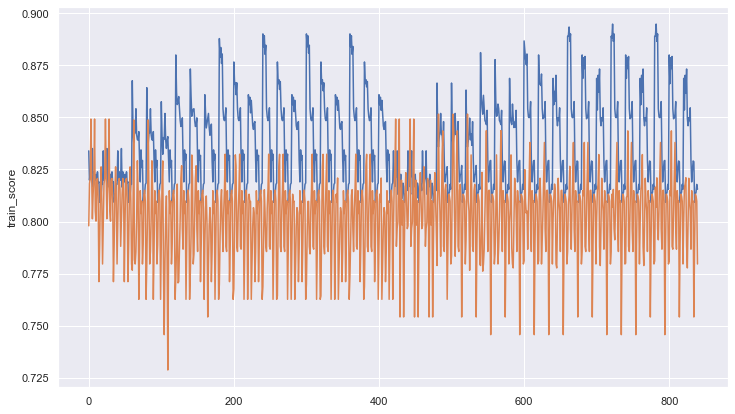

In [19]:
sns.lineplot(y=resultados['train_score'], x=resultados.index)
sns.lineplot(y=resultados['test_score'], x=resultados.index);

In [20]:
best_params = resultados.sort_values(by=['test_score'], ascending=[False]).head(1).drop(columns=['test_score', 'train_score', 'n_splits']).to_dict(orient='records')[0]
best_params

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_split': 24,
 'min_samples_leaf': 2}

In [21]:
modelo = DecisionTreeClassifier(**best_params)
modelo.fit(X, y)
predicoes = modelo.predict(Xvalidation)
resultado = pd.DataFrame()
resultado['PassengerId'] = teste['PassengerId']
resultado['Survived'] = predicoes
resultado.to_csv('../../data/submissions/decision_tree_5.csv', index=False)

## Executando `DecisionTree` com normalização

In [22]:
normalizadores = [StandardScaler(), MaxAbsScaler(), MinMaxScaler(), Normalizer(), RobustScaler()]

In [23]:
resultados = []
for normalizador in normalizadores:
    normalizador.fit(treino_x)
    n_treino_x = normalizador.transform(treino_x)
    n_teste_x = normalizador.transform(teste_x)
    r = dt_grid_search(n_treino_x, treino_y, n_teste_x, teste_y)
    r['normalizador'] = normalizador
    resultados.append(r)
resultados = pd.concat(resultados)

In [24]:
resultados.sort_values(by=['test_score', 'train_score'], ascending=[False, False])

,criterion,max_depth,min_samples_split,min_samples_leaf,train_score,test_score,normalizador
26,gini,7,8,16,0.849719,0.798883,Normalizer()
30,gini,7,16,16,0.849719,0.798883,Normalizer()
34,gini,7,24,16,0.849719,0.798883,Normalizer()
38,gini,11,8,16,0.849719,0.793296,Normalizer()
42,gini,11,16,16,0.849719,0.793296,Normalizer()
...,...,...,...,...,...,...,...
96,entropy,5,8,2,0.837079,0.726257,Normalizer()
100,entropy,5,16,2,0.834270,0.726257,Normalizer()
132,entropy,18,8,2,0.894663,0.720670,Normalizer()
148,entropy,25,16,2,0.890449,0.720670,Normalizer()


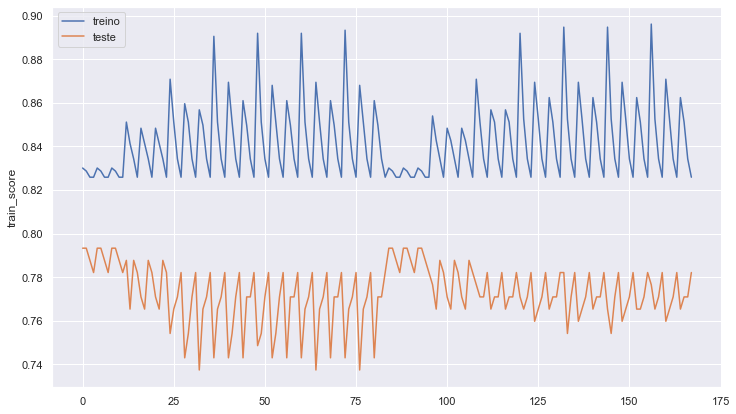

In [25]:
resultados['normalizador'] = resultados['normalizador'].astype(str)
st_resultados = resultados[resultados['normalizador'] == 'StandardScaler()']
sns.lineplot(y=st_resultados['train_score'], x=st_resultados.index, label='treino')
sns.lineplot(y=st_resultados['test_score'], x=st_resultados.index, label='teste');

### Utilizando o `cross_validate`

In [26]:
resultados = []
for normalizador in normalizadores:
    normalizador.fit(X)
    n_x = normalizador.transform(X)
    r = dt_grid_search_cross(n_x, y)
    r['normalizador'] = normalizador
    resultados.append(r)
resultados = pd.concat(resultados)

In [27]:
resultados.sort_values(by=['test_score', 'train_score'], ascending=[False, False])

,criterion,max_depth,min_samples_split,min_samples_leaf,test_score,train_score,n_splits,normalizador
62,gini,5,8,2,0.857181,0.837894,5,MaxAbsScaler()
82,gini,5,16,2,0.857181,0.837894,5,MaxAbsScaler()
62,gini,5,8,2,0.857181,0.837894,5,MinMaxScaler()
82,gini,5,16,2,0.857181,0.837894,5,MinMaxScaler()
482,entropy,5,8,2,0.851563,0.835791,5,StandardScaler()
...,...,...,...,...,...,...,...,...
664,entropy,18,8,2,0.677966,0.906851,15,Normalizer()
804,entropy,50,16,2,0.677966,0.890625,15,Normalizer()
684,entropy,18,16,2,0.677966,0.885817,15,Normalizer()
604,entropy,11,8,2,0.677966,0.880409,15,Normalizer()


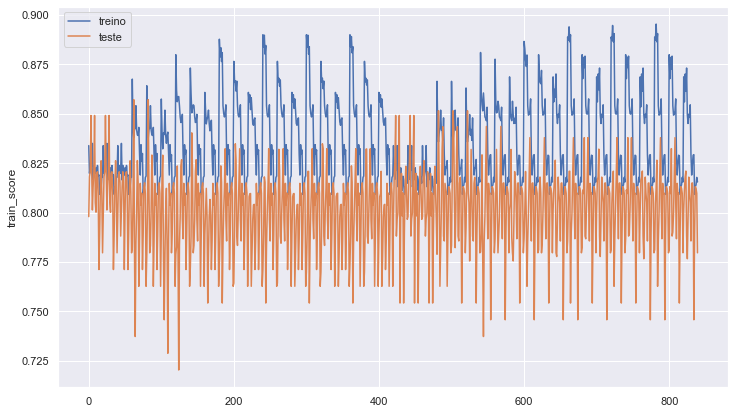

In [28]:
resultados['normalizador'] = resultados['normalizador'].astype(str)
st_resultados = resultados[resultados['normalizador'] == 'MaxAbsScaler()']
sns.lineplot(y=st_resultados['train_score'], x=st_resultados.index, label='treino')
sns.lineplot(y=st_resultados['test_score'], x=st_resultados.index, label='teste');

In [29]:
best_params = resultados.sort_values(by=['test_score'], ascending=[False]).head(1).drop(columns=['test_score', 'train_score', 'n_splits', 'normalizador']).to_dict(orient='records')[0]
best_params

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 8,
 'min_samples_leaf': 2}

In [30]:
normalizador = Normalizer()
normalizador.fit(X)
n_x = normalizador.transform(X)

normalizador = Normalizer()
normalizador.fit(Xvalidation)
t_x = normalizador.transform(Xvalidation)

modelo = DecisionTreeClassifier(**best_params)
modelo.fit(n_x, y)
predicoes = modelo.predict(t_x)
resultado = pd.DataFrame()
resultado['PassengerId'] = teste['PassengerId']
resultado['Survived'] = predicoes
resultado.to_csv('../../data/submissions/decision_tree_6.csv', index=False)

## Conclusão

Foi observado que _sem o fare_ foi possível alcançar a precisão de 77.8% que a random forest tinha obtido apenas com a `DecisionTree` e também que o modelo mais simples foi o que apresentou melhores resultados (`decision_tree_3.csv`).

## Apêndice

Vamos analisar, baseado no modelo com melhor acurácia, a evolução gráfica do mesmo.

Primeiro vamos atualizar o método para conter mais parâmetros

In [77]:
def dt_grid_search(treino_x, treino_y, teste_x, teste_y):
    criterion = ["gini", "entropy"]
    max_depth = range(3, 150, 3)
    min_samples_split = [2, 4, 8, 16, 24]
    min_samples_leaf = [2, 8, 16, 32]
    resultados = []

    for c in criterion:
        for md in max_depth:
            for ms in min_samples_split:
                for ml in min_samples_leaf:
                    modelo = DecisionTreeClassifier(criterion = c, max_depth = md, min_samples_split = ms, min_samples_leaf = ml)
                    modelo.fit(treino_x, treino_y)
                    train_score = modelo.score(treino_x, treino_y)
                    test_score = modelo.score(teste_x, teste_y)
                    resultados.append({
                        "criterion": c,
                        "max_depth" : md,
                        "min_samples_split": ms,
                        "min_samples_leaf": ml,
                        "train_score": train_score,
                        "test_score": test_score
                    })

    return pd.DataFrame(resultados)

In [79]:
resultados = dt_grid_search(treino_x, treino_y, teste_x, teste_y)
resultados.head(5)

,criterion,max_depth,min_samples_split,min_samples_leaf,train_score,test_score
0,gini,3,2,2,0.830056,0.793296
1,gini,3,2,8,0.828652,0.793296
2,gini,3,2,16,0.825843,0.787709
3,gini,3,2,32,0.825843,0.782123
4,gini,3,4,2,0.830056,0.793296


In [71]:
print(resultados['max_depth'].unique())
print(resultados['min_samples_split'].unique())
print(resultados['min_samples_leaf'].unique())
print(resultados['criterion'].unique())

[  3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54
  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 102 105 108
 111 114 117 120 123 126 129 132 135 138 141 144 147]
[ 8 16 24]
[ 2  8 16 32]
['gini' 'entropy']


In [72]:
resultados.drop(columns=['max_depth','min_samples_split', 'min_samples_leaf']).groupby('criterion').describe()

train_score                                                   \
                count      mean       std       min       25%      50%   
criterion                                                                
entropy         588.0  0.846418  0.020109  0.825843  0.825843  0.83427   
gini            588.0  0.845711  0.019461  0.825843  0.825843  0.83427   

                              test_score                               \
                75%       max      count      mean       std      min   
criterion                                                               
entropy    0.852528  0.896067      588.0  0.772061  0.009071  0.75419   
gini       0.851124  0.894663      588.0  0.766636  0.014055  0.73743   

                                                  
                25%      50%       75%       max  
criterion                                         
entropy    0.765363  0.77095  0.782123  0.793296  
gini       0.759777  0.77095  0.782123  0.793296

### Sendo `criterion == 'entropy'`

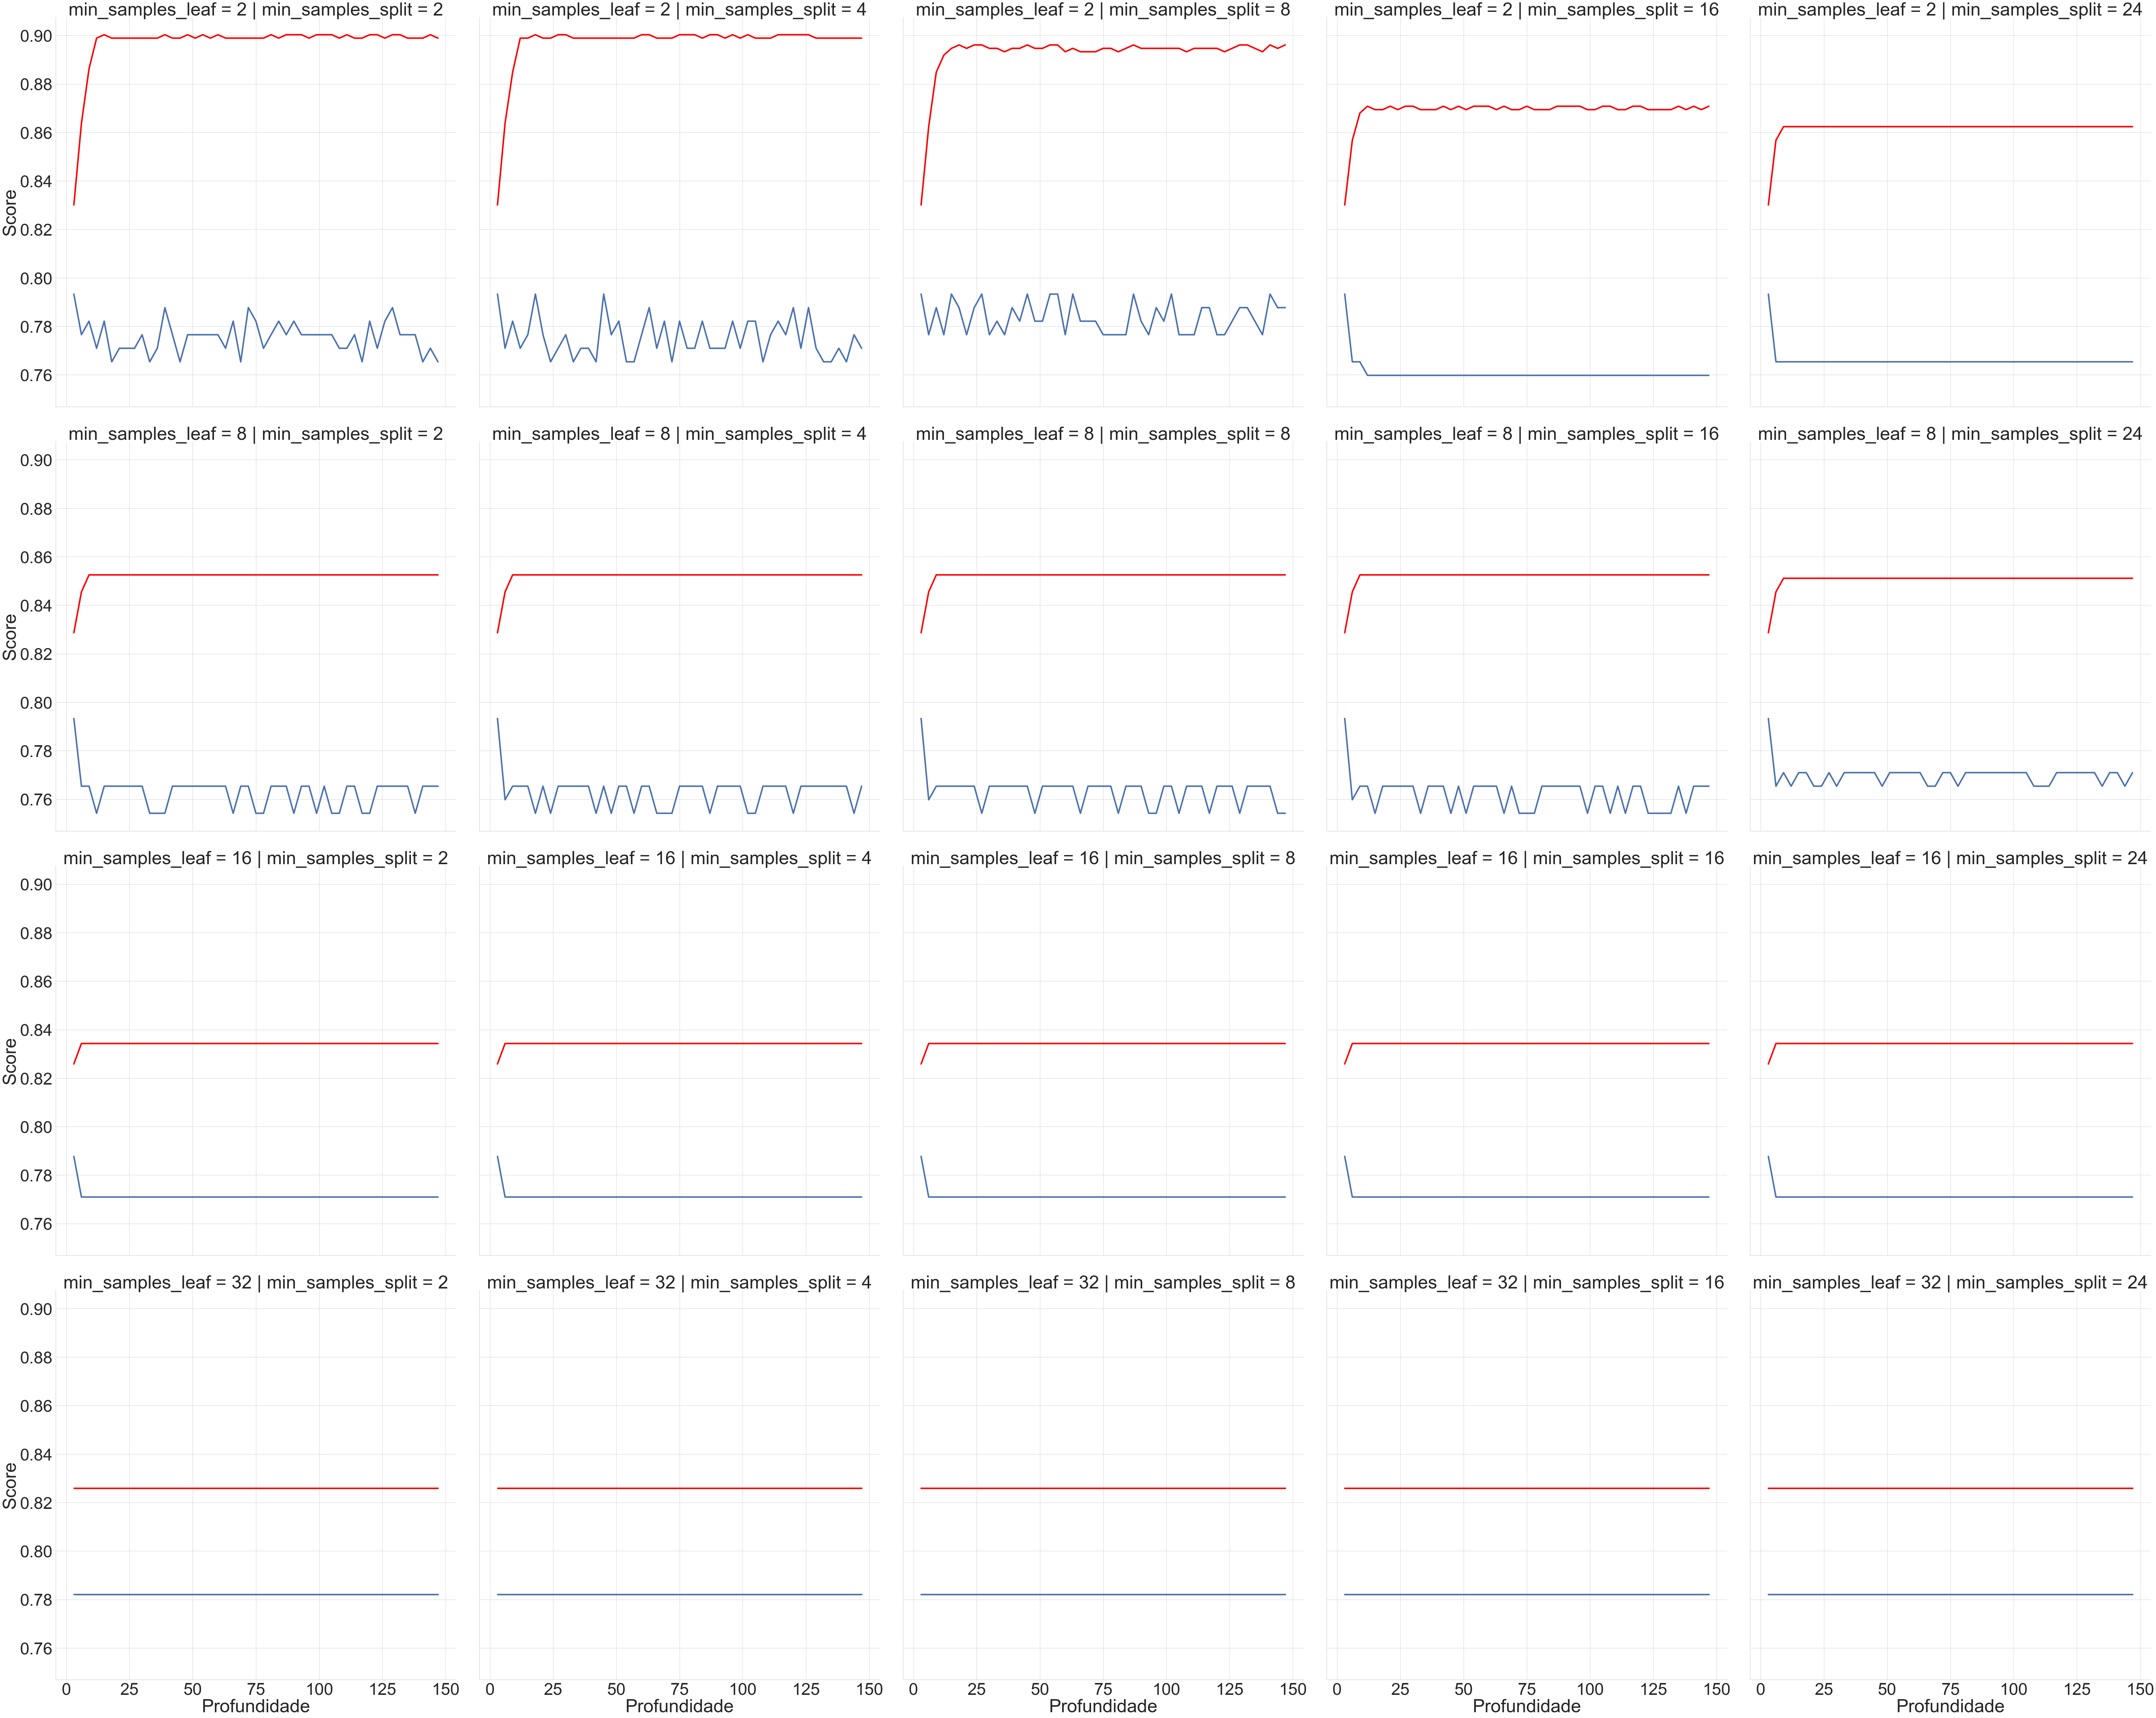

In [80]:
data = resultados.query("criterion == 'entropy'")

sns.set_context("notebook", font_scale=5, rc={"lines.linewidth": 5})
sns.set_style("whitegrid")
g = sns.FacetGrid(data, col="min_samples_split",  row="min_samples_leaf", height=20)
g.map(sns.lineplot, "max_depth", "train_score", color='red', label='treino')
g.map(sns.lineplot, "max_depth", "test_score", label='teste')
g.set_axis_labels("Profundidade", "Score");

## Salvando os datasets editados

In [81]:
treino.to_csv('../../data/processed_v2/train_dummies_2.csv', index=False)
teste.to_csv('../../data/processed_v2/test_dummies_2.csv', index=False)